## Noisy and Rotated Scanned Documents


### Problem Description

An insurance company is working on a system that can perform Optical Character Recognition (OCR) on documents from their archives. Unfortunately, their documents have been scanned at angles ranging from -5° to 5° from the horizontal. To increase OCR accuracy, they need a preprocessing step that determines the angle of a given page so this distortion can be corrected.

### 1- Data Exploration

In [15]:
import os
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from scipy.stats import mode


In [16]:
path = './scan_doc_rotation/'

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']
Total number of images: 600


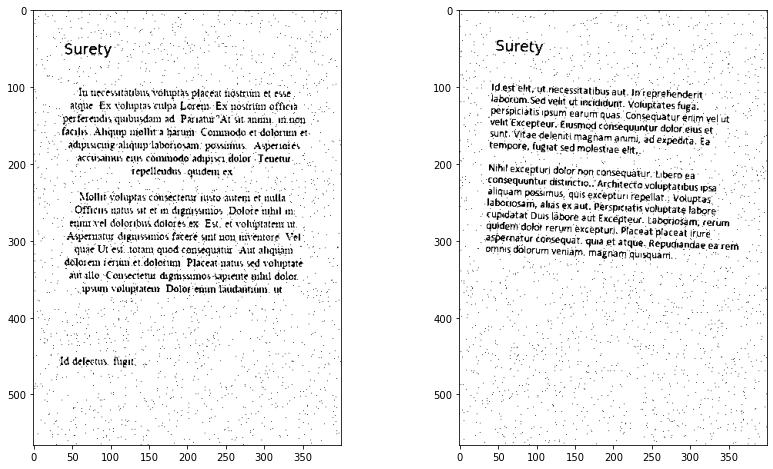

In [17]:
# Load and open images
names = [ file for file in os.listdir(path+'images/') ]
names = sorted(names)
N = len(names)
print(names[:10])

# Load two images to check
images = [Image.open(path+'images/'+names[i]) for i in range(2)]

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(images[0], cmap = 'gray')
plt.subplot(122),plt.imshow(images[1], cmap = 'gray')

print(f'Total number of images: {N}')

### 2- Apply Hough Transform
- Read image as gray scale
- Use canny edge detector
- Customize the range of angles
- Detect all lines on the image
- Get most prominent lines separated by a certain angle 
- Vote among angles of the prominent lines


In [45]:
#%%timeit

def display_Hough_Transform(image_path):
    
    # Use canny edge detector
    image = imread(image_path)
    edges = canny(image)
    
    # Classic straight-line Hough transform
    # Note that the maximum skewed angel 5 degree so we choose angel here between 90 + 6 and 90 - 6 degree
    # That make Algorithm run faster and make a better result  
    tested_angles = np.deg2rad(np.arange(84.0, 96.0))
    h, theta, d = hough_line(edges, theta=tested_angles)
    # Generating figure 1
    fig, axes = plt.subplots(1, 2, figsize=(15, 16))
    ax = axes.ravel()

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(edges, cmap="gray")
    origin = np.array((0, image.shape[1]))


    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[1].plot(origin, (y0, y1), '-r')
        angles.append(angle)
    angle = np.rad2deg(mode(angles)[0][0])
    #Choosing angle using vote
    fixed_angle = -(90 - np.rad2deg(mode(angles)[0][0]))
    ax[1].set_xlim(origin)
    ax[1].set_ylim((edges.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')
    plt.show()
    return angle,fixed_angle

def Hough_Transform(image_path):
    
    # Use canny edge detector
    image = imread(image_path)
    edges = canny(image)
    
    # Classic straight-line Hough transform
    # Note that the maximum skewed angel 5 degree so we choose angel here between 90 + 6 and 90 - 6 degree
    # That make Algorithm run faster and make a better result  
    tested_angles = np.deg2rad(np.arange(84.0, 96.0))
    h, theta, d = hough_line(edges, theta=tested_angles)
       
    _, angles,_ =hough_line_peaks(h, theta, d)
        
    angle = np.rad2deg(mode(angles)[0][0])
    #Choosing angle using vote
    fixed_angle = -(90 - angle)
    
    return angle,fixed_angle
    


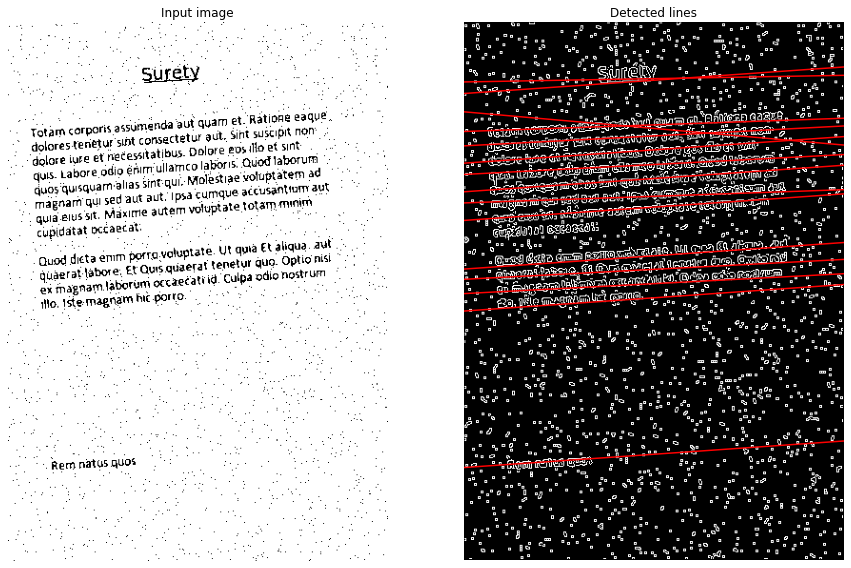

Predicted Angle 86.0, fixed angle -4.0


In [46]:
eg_img = path+'/images/'+names[18]
angle, fixed_angle =display_Hough_Transform(eg_img)
print(f"Predicted Angle {angle}, fixed angle {fixed_angle:.2}")

In [20]:
# Load and open labels
label_names = [ file for file in os.listdir(path+'./labels') ]
label_names = sorted(label_names)
M = len(label_names)

print(label_names[:10])

labels = [ np.loadtxt(path+'./labels/'+label_names[j]) for j in range(M) ]


# Load first 10 labels
[print(labels[i]) for i in range(10)]
print('Total number of labels %d'%len(labels))


['scan_000.txt', 'scan_001.txt', 'scan_002.txt', 'scan_003.txt', 'scan_004.txt', 'scan_005.txt', 'scan_006.txt', 'scan_007.txt', 'scan_008.txt', 'scan_009.txt']
-0.337673521065156
-2.22703348158525
-4.72505826974727
-4.79902371317565
-0.9209119766851366
-1.1685026322366268
3.9676919747808377
0.272255848571775
-4.697980301062572
-1.756942628838055
Total number of labels 500


In [21]:
# Deserialize JSON data lists for training and test sets
with open(path+'train_list.json') as train_data:
    train = json.load(train_data)
    
train_size = len(train)
print('Training set size: %d'%train_size)

with open(path+'test_list.json') as test_data:
    test = json.load(test_data)
    
test_size = len(test)
print('Test set size: %d'%test_size)

Training set size: 500
Test set size: 100


We just have 500 labels data for training and No lables for testing so we going to use them for testing our solution

In [47]:
pred = []
for i in range(M):
    angle,_ = Hough_Transform(path+'/images/'+names[i])
    pred.append(angle)
    

In [48]:
len(pred)

500

In [54]:
df = pd.DataFrame({'Image name': names[:train_size], 'True Rotated angle (deg)': labels,'Pred Rotated angle (deg)'
                  : 90 - np.array(pred)})
df.head(20)

,Image name,True Rotated angle (deg),Pred Rotated angle (deg)
0,scan_000.png,-0.337673521065156,0.0
1,scan_001.png,-2.22703348158525,-2.0
2,scan_002.png,-4.72505826974727,-5.0
3,scan_003.png,-4.79902371317565,-5.0
4,scan_004.png,-0.9209119766851366,-1.0
5,scan_005.png,-1.1685026322366268,-1.0
6,scan_006.png,3.9676919747808377,4.0
7,scan_007.png,0.272255848571775,0.0
8,scan_008.png,-4.697980301062572,-5.0
9,scan_009.png,-1.756942628838055,-2.0


Compute mean square error over 500 label data

In [50]:
np.sum(np.square(np.array(labels) - (90 - np.array(pred))))/M

0.09492877999439271

In [51]:
np.sum(np.square(np.round(np.array(labels)) - np.round((90 - np.array(pred)))))/M

0.054

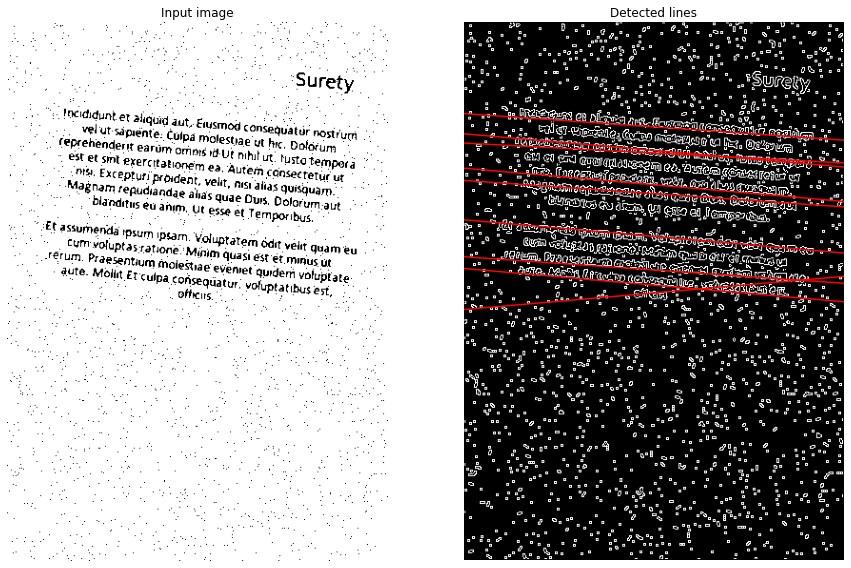

(95.0, 5.0)


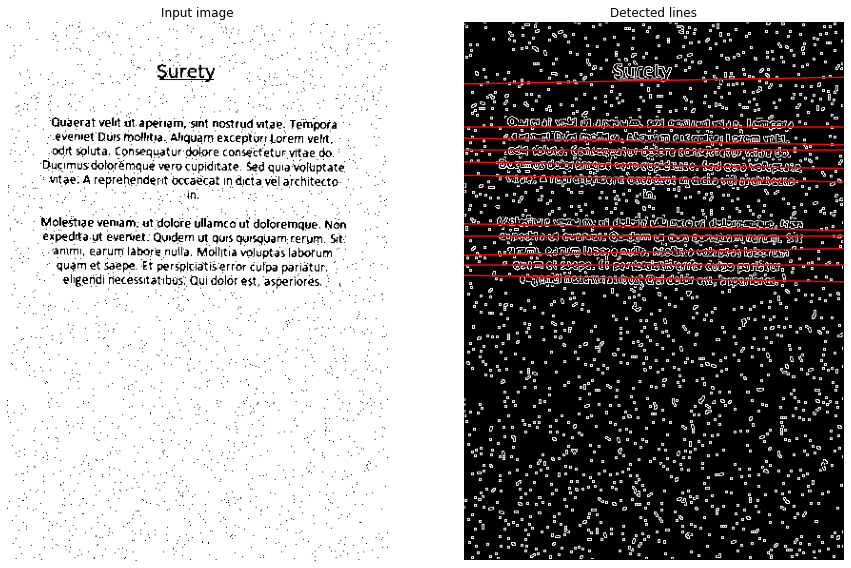

(91.0, 1.0)


In [53]:
for j in [path+'images/'+names[i] for i in [40,42]]:
    print(display_Hough_Transform(j))

### Result
Mean square error = 0.09492877999439271 without rounding which is very imprassive.


Have fun, and I hope you enjoy my notebook just as much as I do.